In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.stats.stats import pearsonr
from scipy.stats import linregress
%matplotlib inline
plt.style.use('seaborn')

In [2]:
retweet_cascade = pd.read_csv('cascade_with_influence.csv')

In [6]:
humans = retweet_cascade[retweet_cascade['predicted'] == 0]

In [7]:
bots = retweet_cascade[retweet_cascade['predicted'] == 1]

In [9]:
humans['influence'].mean()

4.064464173471694

In [11]:
humans['influence'].std()

69.7499725856933

In [10]:
bots['influence'].mean()

8.129450210387756

In [12]:
bots['influence'].std()

110.3166878366874

In [ ]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

In [2]:
df = pd.read_csv('../../data/all_cleaned.csv')

In [4]:
tweet_metrics = pd.read_csv('metrics_retweet_cascade.csv')

In [5]:
len(tweet_metrics)

329606

In [6]:
tweet_metrics['size'].mean()

17.022578472479264

In [7]:
human_tweets = retweet_cascade[retweet_cascade['predicted'] == 0]
bot_tweets = retweet_cascade[retweet_cascade['predicted'] == 1]

In [8]:
human_tweets['influence'].mean()

4.064464173471694

In [9]:
human_tweets['influence'].std()

69.7499725856933

In [10]:
bot_tweets['influence'].mean()

8.129450210387756

In [11]:
bot_tweets['influence'].std()

110.3166878366874

In [12]:
#Influence over different size

In [13]:
tweet_metrics.columns

Index(['SentiStrength_mean', 'SentiStrength_std', 'bot_percentage',
       'bot_percentage_10', 'bot_percentage_25', 'bot_percentage_5',
       'bots_SentiStrength_mean', 'bots_SentiStrength_std', 'bots_count',
       'bots_count_10', 'bots_count_25', 'bots_count_5', 'bots_influence_mean',
       'bots_influence_mean_10', 'bots_influence_mean_25',
       'bots_influence_mean_5', 'bots_influence_std', 'bots_influence_std_10',
       'bots_influence_std_25', 'bots_influence_std_5',
       'humans_SentiStrength_mean', 'humans_SentiStrength_std', 'humans_count',
       'humans_count_10', 'humans_count_25', 'humans_count_5',
       'humans_influence_mean', 'humans_influence_mean_10',
       'humans_influence_mean_25', 'humans_influence_mean_5',
       'humans_influence_std', 'humans_influence_std_10',
       'humans_influence_std_25', 'humans_influence_std_5', 'id',
       'influence_mean', 'influence_mean_10', 'influence_mean_25',
       'influence_mean_5', 'influence_std', 'influence_std_

In [14]:
tweet_metrics = tweet_metrics[tweet_metrics['size'] > 10].reset_index(drop=True)

In [15]:
parent_df = df[df['ID'].isin(tweet_metrics['ID'])]

In [16]:
children_df = df[df['in_response_to'].isin(tweet_metrics['ID'])]

In [17]:
parent_df['retweet_followers_ratio'] = parent_df['Retweets']/parent_df['followers_count']

/home/warproxxx/anaconda3/envs/meta_analyse/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [18]:
parent_df.sort_values('retweet_followers_ratio', ascending=False)

,ID,Tweet,Time,User,Likes,Replies,Retweets,in_response_to,response_type,url,vader_emotion,polarity,subjectivity,Positive,Negative,predicted,followers_count,retweet_followers_ratio
3062790,1058269313314902017,"stay hydrated, don’t forget to stretch. wash y...",1541146040,tulili,142,2,31,0,tweet,[],-0.6249,0.150000,0.844444,1,-3,1,0.0,inf
3049068,1057967462325645317,#MTVEMABiggestFansTaylor \nVote for the queen ...,1541074073,mjfangirl1,15,0,83,0,tweet,[],0.0000,0.000000,0.000000,2,-1,1,0.0,inf
2816894,1058873601120555008,Icb SVT don’t even get a proper sleep bcs of p...,1541290114,onlyforwonu,86,1,41,0,tweet,[],0.7003,-0.118750,0.402083,1,-1,1,0.0,inf
4607341,1058494187564224512,Lifelong Republican. My first vote was for Rea...,1541199654,barrysteinfeld,294,21,48,0,tweet,[],0.0000,0.075000,0.466667,1,-1,0,0.0,inf
5076353,1058850247529713664,It's serious now! @realDonaldTrump is going fu...,1541284546,jard_gray_beard,19,3,13,1058814735011995648,quoted_retweet,['https://twitter.com/WilDonnelly/status/10588...,0.5983,0.195833,0.579167,3,-3,1,0.0,inf
5661561,1059642800717721601,I vote @mainedcm ...,1541473505,rscherazade,32,0,60,0,tweet,[],0.8122,0.400000,0.585417,1,-1,0,0.0,inf
3054318,1058100441878331394,GO VOTE THE EARTH IS FUCKING DYING https://twi...,1541105778,nuocmammi,84701,90,47745,1058099131149889536,quoted_retweet,['https://twitter.com/NYDailyNews/status/10580...,0.0000,-0.600000,0.800000,1,-4,0,130.0,367.269231
5656702,1059351361811169281,These are the people that vote when you don’t....,1541404021,samiewamiee,165278,213,87923,1056683061323030400,quoted_retweet,['https://twitter.com/softrhodey/status/105668...,0.0000,0.000000,0.000000,1,-1,0,523.0,168.112811
75844,1054536829196619776,If you’re a California resident and are planni...,1540256147,dannytriplesix,75880,295,43762,0,tweet,[],-0.1154,0.116667,0.516667,1,-2,0,274.0,159.715328
95221,1056268854610067458,Robert Bowers the man who just murdered 10 Jew...,1540669094,motorcitykevin,139823,1377,59115,0,tweet,[],-0.8779,0.150000,0.275000,2,-3,0,404.0,146.324257


In [19]:
high_retweets = parent_df[parent_df['retweet_followers_ratio'] > 0.1]

In [20]:
high_metrics = tweet_metrics[tweet_metrics['ID'].isin(high_retweets['ID'])]

In [21]:
(sum(high_metrics['bot_percentage']  * high_metrics['size'])/sum(high_metrics['size']))

6.858823800554388

In [22]:
high_retweets[high_retweets['predicted'] == 1]

,ID,Tweet,Time,User,Likes,Replies,Retweets,in_response_to,response_type,url,vader_emotion,polarity,subjectivity,Positive,Negative,predicted,followers_count,retweet_followers_ratio
7997,899154494608392192,"""If fascism ever comes to America, it will com...",1503210111,politick_rick,4924,201,4324,0,tweet,[],0.0000,0.000000,0.000000,1,-1,1,29746.0,0.145364
14032,962331556831481858,As a mom of 10 children I would like to person...,1518272697,real_peachykeen,12824,897,5961,0,tweet,[],0.9136,0.033333,0.166667,2,-1,1,54566.0,0.109244
14455,966941967031582720,Her name was #AlyssaAlhadeff.\nShe was killed ...,1519371904,ithasbegun2016,7843,358,9314,0,tweet,[],-0.6671,-0.200000,0.000000,1,-4,1,40832.0,0.228105
17791,989636229477085185,10 Poorest Cities in America - % below poverty...,1524782638,usatrump45,16782,1265,12991,0,tweet,[],-0.7783,0.000000,0.000000,1,-2,1,44918.0,0.289216
20656,1004892979256025088,For Trump Supporters Who need some inspiration...,1528420130,president1trump,12017,1476,10231,0,tweet,[],0.6114,0.000000,0.000000,2,-4,1,62045.0,0.164896
20895,1060130261118210051,This to ME was the biggest disappointment of t...,1541589725,raymysterio305,13699,1754,6239,0,tweet,[],0.3561,-0.016875,0.440000,3,-3,1,49877.0,0.125088
22031,1009903408529190915,"For as long as I'm alive,\nThis face will fore...",1529614710,blueghost40_,22207,1140,10037,0,tweet,[],0.3818,0.025000,0.400000,1,-1,1,39181.0,0.256170
23673,1013860979141218305,I am a MAGA candidate running for Ohio US Hous...,1530558268,bevgoldstein,8385,363,5461,0,tweet,[],-0.8176,-0.166667,0.155556,1,-3,1,13215.0,0.413243
27044,1053691148856782848,What an Amazing moment in history. My first Tr...,1540054521,christianllamar,12832,504,6466,0,tweet,[],0.3836,0.045000,0.495000,1,-2,1,37343.0,0.173152
27092,1059799225876152321,Joe Scarborough just called all Trump Supporte...,1541510800,christianllamar,5109,1140,4123,0,tweet,[],0.7066,-0.058333,0.800000,3,-2,1,37343.0,0.110409


In [23]:
selected_tweets = tweet_metrics[tweet_metrics['bot_percentage_5'] > 0]

In [24]:
selected_tweets = selected_tweets.sort_values('bot_percentage_5')

In [25]:
merged_followers_selected = selected_tweets.merge(df, on='ID')

In [26]:
def get_groups_size_average(df):
    df = df[['bot_percentage', 'bot_percentage_10', 'bot_percentage_25', 'bot_percentage_5', 'size', 'followers_count']]
#     df[['bot_percentage', 'bot_percentage_5', 'bot_percentage_10', 'bot_percentage_25']] = df[['bot_percentage', 'bot_percentage_5', 'bot_percentage_10', 'bot_percentage_25']] * 100
    df['follower_range'] = pd.cut(df['followers_count'], [0, 100, 1000,10000,100000,1000000,10000000000], labels=['0-100', '100-1k', '1k-10k', '10k-100k', '100k-1M', '1M+'])
    df['bot_percentage_range'] = pd.cut(df['bot_percentage'], [0,5,10,15,25,50,100], labels=['0-5', '5-10', '10-15', '15-25', '25-50', '50-100'])
    df['bot_5_percentage_range'] = pd.cut(df['bot_percentage_5'], [0,5,10,15,25,50,100], labels=['0-5', '5-10', '10-15', '15-25', '25-50', '50-100'])
    df['bot_10_percentage_range'] = pd.cut(df['bot_percentage_10'], [0,5,10,15,25,50,100], labels=['0-5', '5-10', '10-15', '15-25', '25-50', '50-100'])
    df['bot_25_percentage_range'] = pd.cut(df['bot_percentage_25'], [0,5,10,15,25,50,100], labels=['0-5', '5-10', '10-15', '15-25', '25-50', '50-100'])
    df = df[['size', 'follower_range', 'bot_percentage_range', 'bot_5_percentage_range', 'bot_10_percentage_range', 'bot_25_percentage_range', 'bot_percentage_25']]

    return df

tweet_metrics = pd.read_csv('metrics_retweet_cascade.csv')

In [27]:
tweet_merged = df.merge(tweet_metrics, on='ID')

In [28]:
a = tweet_merged[['bot_percentage', 'bot_percentage_10', 'bot_percentage_25', 'bot_percentage_5', 'size', 'followers_count']]

In [29]:
a

,bot_percentage,bot_percentage_10,bot_percentage_25,bot_percentage_5,size,followers_count
0,0.000000,0.000000,0.000000,0.0,4,58531067.0
1,33.333333,100.000000,80.000000,100.0,18,58531067.0
2,25.000000,0.000000,0.000000,0.0,4,58531067.0
3,50.000000,100.000000,100.000000,100.0,4,58531067.0
4,14.285714,0.000000,50.000000,0.0,7,58531067.0
5,0.000000,0.000000,0.000000,0.0,10,58531067.0
6,16.666667,100.000000,50.000000,100.0,6,58531067.0
7,4.347826,33.333333,16.666667,0.0,23,58531067.0
8,1.310044,0.000000,1.724138,0.0,229,58531067.0
9,2.959184,1.020408,3.265306,0.0,980,58531067.0


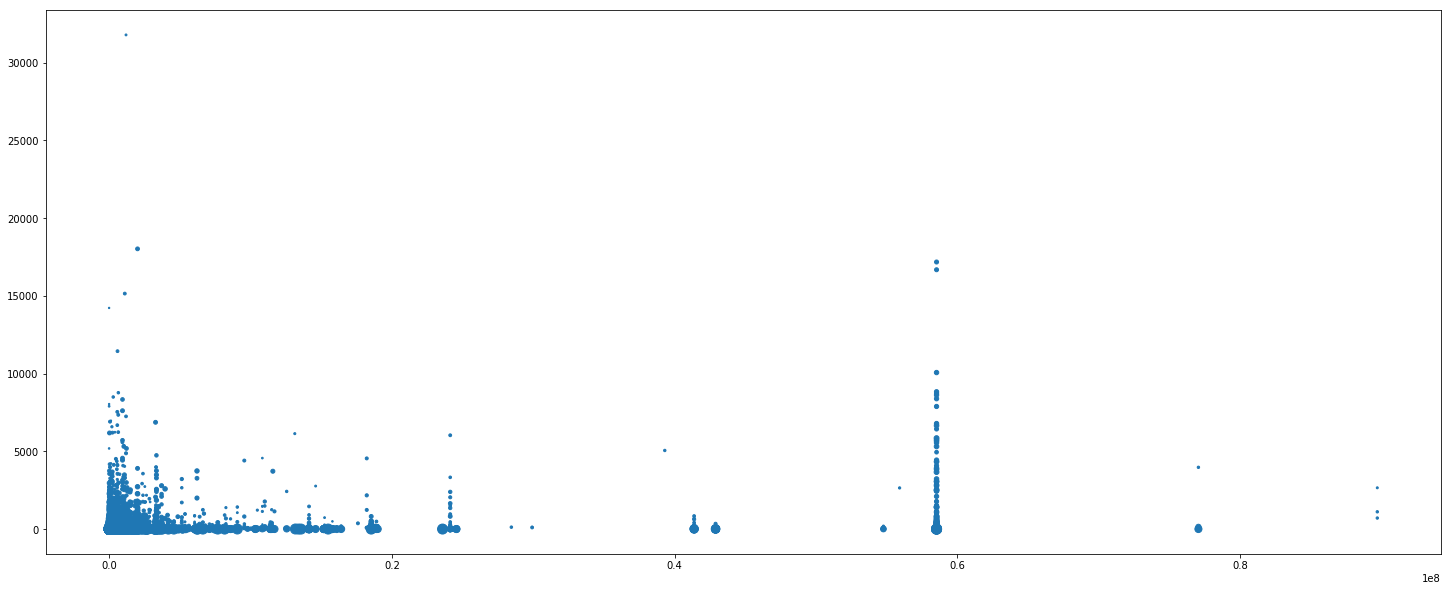

In [30]:
fig, ax = plt.subplots(figsize=(25,10))

# ax.set_xticks(placeholder)
# ax.set_xticklabels(actual)

# ax.set_yscale('log') #do this later
# ax.set_xscale('log') #do this later
# ax.boxplot()

ax.scatter(a['followers_count'], a['size'], s = a['bot_percentage_25']) #make as good chart as the interaction chart

In [31]:
tweet_merged = get_groups_size_average(tweet_merged)

/home/warproxxx/anaconda3/envs/meta_analyse/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/warproxxx/anaconda3/envs/meta_analyse/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/warproxxx/anaconda3/envs/meta_analyse/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [32]:
tweet_merged

,size,follower_range,bot_percentage_range,bot_5_percentage_range,bot_10_percentage_range,bot_25_percentage_range,bot_percentage_25
0,4,1M+,NaN,NaN,NaN,NaN,0.000000
1,18,1M+,25-50,50-100,50-100,50-100,80.000000
2,4,1M+,15-25,NaN,NaN,NaN,0.000000
3,4,1M+,25-50,50-100,50-100,50-100,100.000000
4,7,1M+,10-15,NaN,NaN,25-50,50.000000
5,10,1M+,NaN,NaN,NaN,NaN,0.000000
6,6,1M+,15-25,50-100,50-100,25-50,50.000000
7,23,1M+,0-5,NaN,25-50,15-25,16.666667
8,229,1M+,0-5,NaN,NaN,0-5,1.724138
9,980,1M+,0-5,NaN,0-5,0-5,3.265306


In [38]:
retu = tweet_merged.groupby(['follower_range', 'bot_25_percentage_range']).apply(lambda x: x.mean())

In [47]:
retu = retu.reset_index().drop('level_2', axis=1).rename(columns={0: 'size'})

In [48]:
actual = ["0-100", "100-1k", "10k-100k", "100k-1M", "1M+"]
placeholder = [100, 200, 300, 400, 500]


def convert_to_axis(x):
    global actual
    global placeholder
    
    for count, value in enumerate(actual):
        if value == x:
            break
            
    return placeholder[count]

retu['x_axis'] = retu['follower_range'].apply(convert_to_axis)

In [52]:
retu

,follower_range,bot_25_percentage_range,size,x_axis
0,0-100,0-5,79.500000,100
1,0-100,0-5,NaN,100
2,0-100,0-5,NaN,100
3,0-100,0-5,4.880952,100
4,0-100,5-10,107.578947,100
5,0-100,5-10,8.425458,100
6,0-100,10-15,47.857143,100
7,0-100,10-15,12.778631,100
8,0-100,15-25,38.222222,100
9,0-100,15-25,21.639218,100


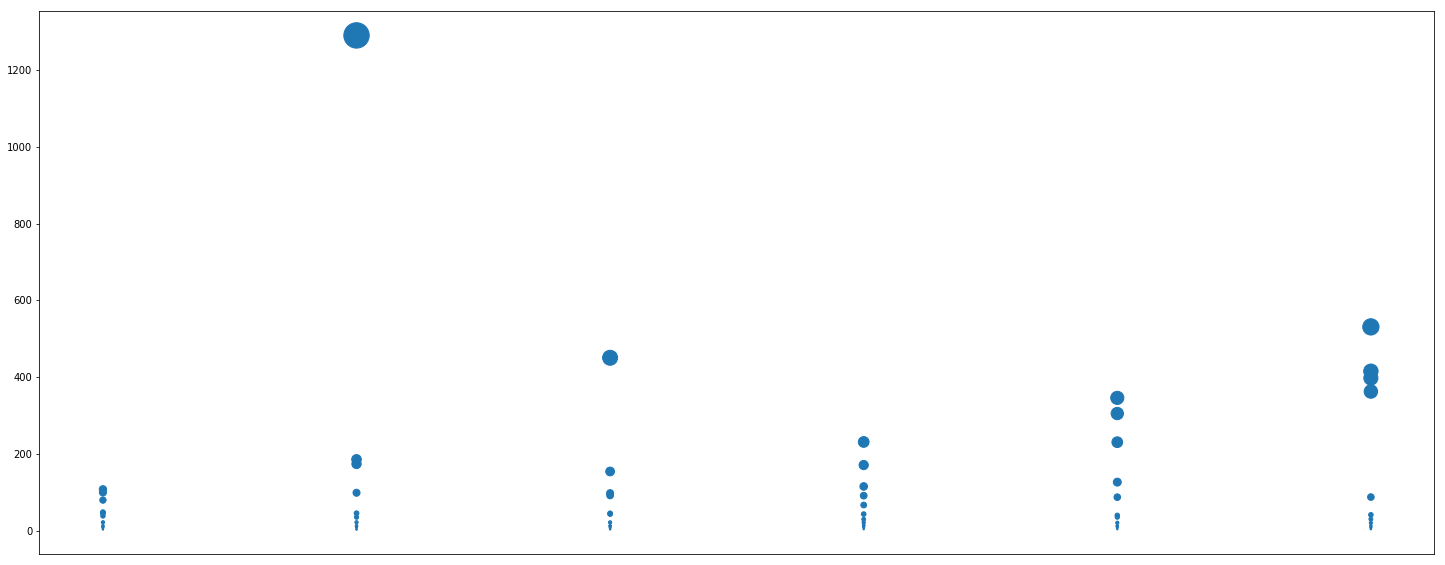

In [91]:
fig, ax = plt.subplots(figsize=(25,10))

ax.set_xticks(placeholder)
ax.set_xticklabels(actual)

# ax.set_yscale('log') #do this later

ax.scatter(retu['follower_range'],retu['size'], s=retu['size']/2 ) #set x label and then set the size of ball

In [56]:
metric_cascade_original = pd.read_csv('metrics_retweet_cascade.csv')

In [57]:
aa = metric_cascade_original[['bots_influence_mean', 'humans_influence_mean', 'size', 'ID', 'bot_percentage']]

In [58]:
aa = aa.dropna()

In [59]:
aa.drop('ID', axis=1).corr() #More likely to be bigger if the number of bots is less

,bots_influence_mean,humans_influence_mean,size,bot_percentage
bots_influence_mean,1.000000,0.143555,0.284230,-0.258319
humans_influence_mean,0.143555,1.000000,0.250742,-0.543688
size,0.284230,0.250742,1.000000,-0.137157
bot_percentage,-0.258319,-0.543688,-0.137157,1.000000


In [61]:
tweet_metrics['bots_influence_mean'] = tweet_metrics['bots_influence_mean'].fillna(value=0).fillna(value=0)
tweet_metrics['size'] = tweet_metrics['size'].fillna(value=0)

In [62]:
temp_calc = tweet_metrics[tweet_metrics['bots_influence_mean'] > 0]

In [63]:
pearsonr(temp_calc['bot_percentage_25'], temp_calc['size']) #pvalue of zero == high significance

(-0.07338509904456178, 8.046351177331314e-168)

In [64]:
linregress(temp_calc['bots_influence_mean'], temp_calc['size']) #pvalue of zero == high significance

LinregressResult(slope=19.697585143163277, intercept=-25.96043817365593, rvalue=0.2857022561877218, pvalue=0.0, stderr=0.1758363772604689)

In [65]:
corr = tweet_metrics[['size', 'bot_percentage', 'bot_percentage_5', 'bot_percentage_10', 'bot_percentage_25', 'bots_influence_mean', 'bots_influence_mean_5', 'bots_influence_mean_10', 'bots_influence_mean_25', 'bots_influence_mean', 'humans_influence_mean', 'ID']].set_index('ID').corr()

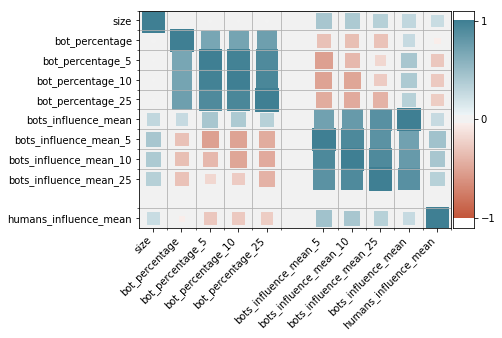

In [68]:
corrplot(corr)

In [69]:
corr

,size,bot_percentage,bot_percentage_5,bot_percentage_10,bot_percentage_25,bots_influence_mean,bots_influence_mean_5,bots_influence_mean_10,bots_influence_mean_25,bots_influence_mean,humans_influence_mean
size,1.000000,-0.011139,0.006604,0.002086,-0.003644,0.290448,0.427527,0.398871,0.356464,0.290448,0.249184
bot_percentage,-0.011139,1.000000,0.689043,0.704702,0.748347,0.263033,-0.321074,-0.337848,-0.317515,0.263033,-0.043396
bot_percentage_5,0.006604,0.689043,1.000000,0.978535,0.921196,0.427575,-0.529230,-0.380105,-0.184483,0.427575,-0.278529
bot_percentage_10,0.002086,0.704702,0.978535,1.000000,0.942182,0.400698,-0.513021,-0.497847,-0.258939,0.400698,-0.272043
bot_percentage_25,-0.003644,0.748347,0.921196,0.942182,1.000000,0.348127,-0.456813,-0.460811,-0.416937,0.348127,-0.248212
bots_influence_mean,0.290448,0.263033,0.427575,0.400698,0.348127,1.000000,0.731454,0.787293,0.861653,1.000000,0.270371
bots_influence_mean_5,0.427527,-0.321074,-0.529230,-0.513021,-0.456813,0.731454,1.000000,0.928638,0.847683,0.731454,0.466343
bots_influence_mean_10,0.398871,-0.337848,-0.380105,-0.497847,-0.460811,0.787293,0.928638,1.000000,0.915036,0.787293,0.434215
bots_influence_mean_25,0.356464,-0.317515,-0.184483,-0.258939,-0.416937,0.861653,0.847683,0.915036,1.000000,0.861653,0.345170
bots_influence_mean,0.290448,0.263033,0.427575,0.400698,0.348127,1.000000,0.731454,0.787293,0.861653,1.000000,0.270371


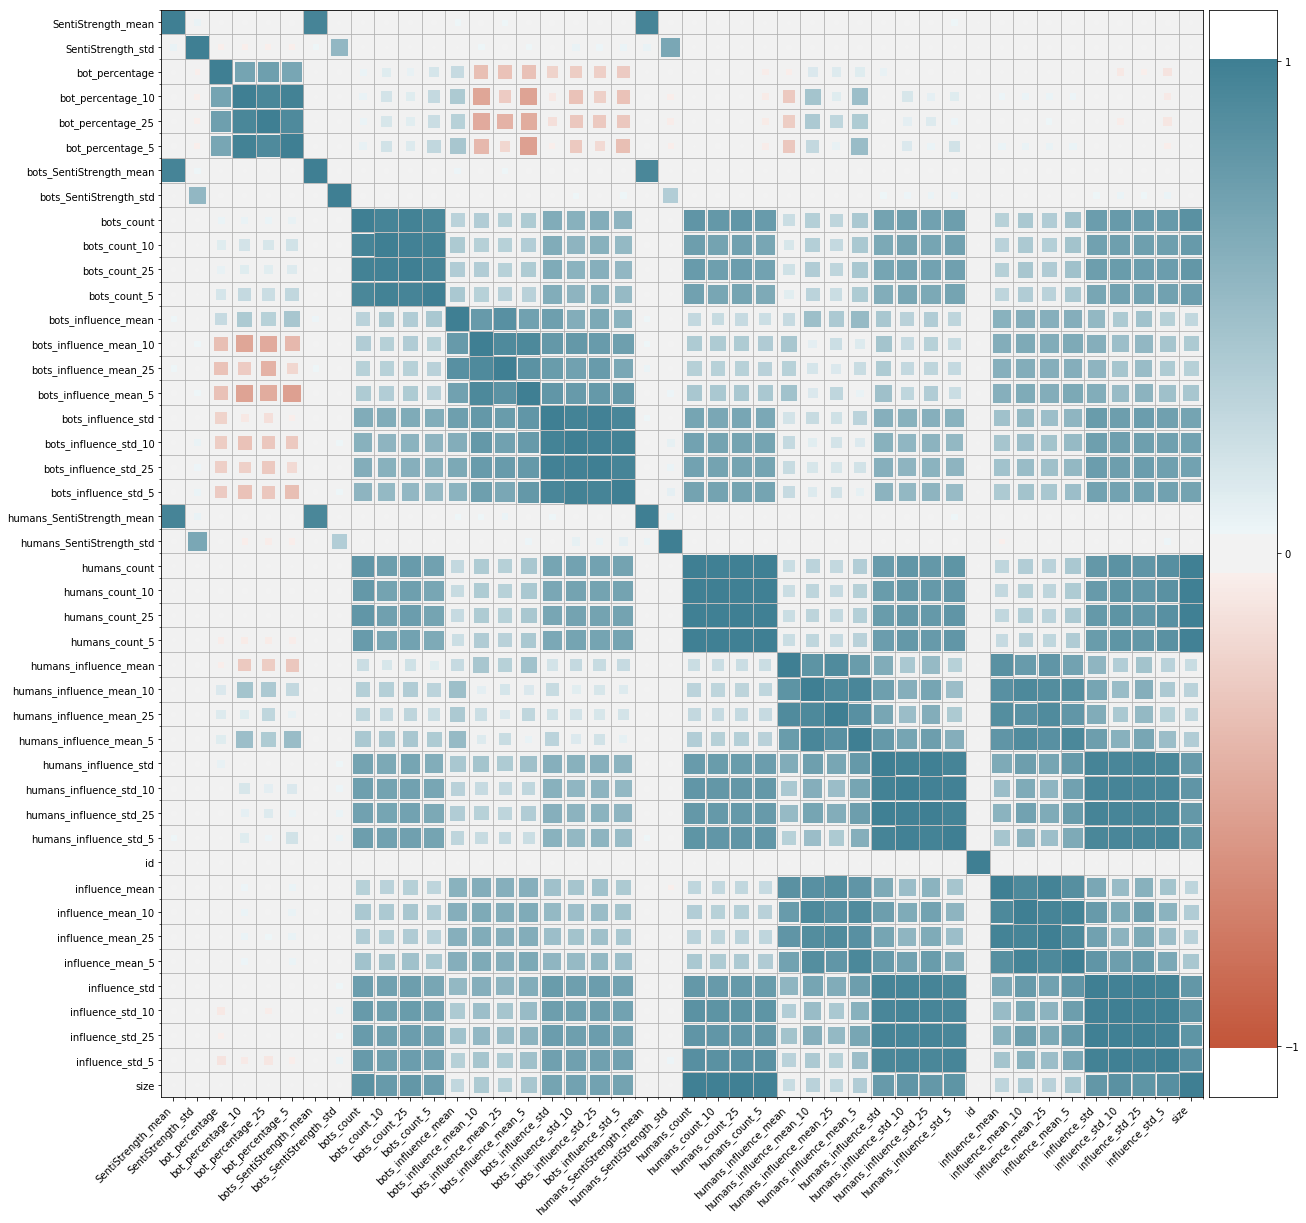

In [70]:
plt.figure(figsize=(20, 20))
corrplot(tweet_metrics.set_index('ID').corr())

In [54]:
#There is correlation between influence and size
corr

,size,bot_percentage,bot_percentage_5,bot_percentage_10,bot_percentage_25,bots_influence_mean,bots_influence_mean_5,bots_influence_mean_10,bots_influence_mean_25,bots_influence_mean,humans_influence_mean
size,1.000000,-0.011139,0.006604,0.002086,-0.003644,0.290448,0.427527,0.398871,0.356464,0.290448,0.249184
bot_percentage,-0.011139,1.000000,0.689043,0.704702,0.748347,0.263033,-0.321074,-0.337848,-0.317515,0.263033,-0.043396
bot_percentage_5,0.006604,0.689043,1.000000,0.978535,0.921196,0.427575,-0.529230,-0.380105,-0.184483,0.427575,-0.278529
bot_percentage_10,0.002086,0.704702,0.978535,1.000000,0.942182,0.400698,-0.513021,-0.497847,-0.258939,0.400698,-0.272043
bot_percentage_25,-0.003644,0.748347,0.921196,0.942182,1.000000,0.348127,-0.456813,-0.460811,-0.416937,0.348127,-0.248212
bots_influence_mean,0.290448,0.263033,0.427575,0.400698,0.348127,1.000000,0.731454,0.787293,0.861653,1.000000,0.270371
bots_influence_mean_5,0.427527,-0.321074,-0.529230,-0.513021,-0.456813,0.731454,1.000000,0.928638,0.847683,0.731454,0.466343
bots_influence_mean_10,0.398871,-0.337848,-0.380105,-0.497847,-0.460811,0.787293,0.928638,1.000000,0.915036,0.787293,0.434215
bots_influence_mean_25,0.356464,-0.317515,-0.184483,-0.258939,-0.416937,0.861653,0.847683,0.915036,1.000000,0.861653,0.345170
bots_influence_mean,0.290448,0.263033,0.427575,0.400698,0.348127,1.000000,0.731454,0.787293,0.861653,1.000000,0.270371


In [71]:
tweet_metrics['bot_percentage'].mean()

14.722528528883405

In [72]:
tweet_metrics['bots_influence_mean'].mean()

1.3252601866274343

In [73]:
tweet_metrics['humans_influence_mean'].mean()

2.0060459671307003

In [74]:
tweet_metrics.sort_values('size', ascending=False)[:100]

,SentiStrength_mean,SentiStrength_std,bot_percentage,bot_percentage_10,bot_percentage_25,bot_percentage_5,bots_SentiStrength_mean,bots_SentiStrength_std,bots_count,bots_count_10,...,influence_mean,influence_mean_10,influence_mean_25,influence_mean_5,influence_std,influence_std_10,influence_std_25,influence_std_5,size,ID
99621,6.987605,0.221186,5.001888,4.435357,3.611426,5.660377,6.982578,0.212485,1590,141,...,10.638308,84.241443,38.283921,155.247439,408.870898,1279.459750,815.116314,1800.858086,31788,1058421408320098306
132720,6.000372,0.038559,2.129953,2.601263,2.215284,2.303120,6.000000,0.000000,573,70,...,5.293091,37.585556,18.082250,73.887225,300.270836,918.565676,600.355289,1298.019662,26902,1058560409827991554
66959,5.006712,0.320539,12.719104,17.082640,14.311072,22.616408,5.003101,0.167155,2293,308,...,7.432547,54.830887,25.143088,108.247668,283.788719,879.336089,562.229508,1241.255347,18028,1058216994464509953
76844,4.916128,0.509978,13.480007,21.000582,16.224395,24.767442,4.942611,0.407728,2316,361,...,5.790425,44.024601,18.899482,86.866922,250.926646,787.459461,499.116911,1111.980063,17181,1058354748578033664
155742,5.003057,0.397574,12.054187,19.652487,15.847519,23.113772,5.016641,0.313381,2011,328,...,6.516941,51.660633,22.129006,101.357740,246.788273,778.539177,493.133091,1098.706818,16683,1058827516427808768
103615,4.984422,0.495962,6.415842,9.438944,7.919747,10.422164,4.990000,0.370167,972,143,...,10.494359,86.273401,36.554514,150.960892,319.774456,972.980406,622.760936,1282.536176,15150,1058447554634047489
60445,5.001968,0.069109,2.129753,1.475755,1.883610,1.544944,5.014925,0.122169,303,21,...,8.921380,72.741654,31.849508,134.211693,264.130735,818.878122,526.038783,1125.852952,14227,1058100441878331394
69608,4.033636,0.369673,6.535034,10.480349,7.791754,11.692845,4.089686,0.562356,748,120,...,9.495055,78.511742,33.515915,154.515174,261.233585,809.182436,517.714758,1138.827972,11446,1058313835273248768
153672,4.065237,0.461006,14.973687,24.007937,19.301033,26.984127,4.022634,0.282664,1508,242,...,3.071674,21.317137,9.182507,41.500466,141.898499,448.306683,283.736259,633.670838,10071,1058820790546821120
87682,4.002899,0.168184,5.248425,6.793207,6.197521,7.984032,4.006452,0.080322,525,68,...,7.992087,63.030193,28.855205,124.919457,230.802626,693.119659,460.990307,976.292020,10003,1058384786388082688


In [75]:
successes = tweet_metrics[tweet_metrics['bot_percentage'] > 15]

In [76]:
successes = successes[successes['size'] > 100]

In [77]:
successes.sort_values('bots_influence_mean', ascending=False)

,SentiStrength_mean,SentiStrength_std,bot_percentage,bot_percentage_10,bot_percentage_25,bot_percentage_5,bots_SentiStrength_mean,bots_SentiStrength_std,bots_count,bots_count_10,...,influence_mean,influence_mean_10,influence_mean_25,influence_mean_5,influence_std,influence_std_10,influence_std_25,influence_std_5,size,ID
5733,3.992308,0.196723,20.000000,76.923077,39.393939,100.000000,4.000000,0.000000,26,10,...,9.014928,75.492607,31.280959,117.195032,28.487870,58.160393,50.819637,19.989721,130,1053036880311328768
76992,4.000000,0.167248,15.021834,31.304348,19.512195,37.931034,4.017857,0.133631,172,36,...,7.846575,53.151036,24.489715,88.484582,74.098156,209.709501,139.619776,268.191107,1145,1058355202904879104
127188,3.061281,0.328582,17.827298,86.111111,46.666667,100.000000,3.000000,0.000000,64,31,...,7.641375,63.172290,26.091094,71.269900,32.781479,84.995605,61.402966,82.642452,359,1058531426851639296
56734,5.979452,0.341784,21.917808,73.333333,43.243243,100.000000,6.000000,0.000000,32,11,...,7.387592,62.458019,25.944723,116.233786,28.469555,69.071209,52.816693,49.594593,146,1058013431935238144
21896,3.166948,0.623948,17.875211,38.333333,27.516779,53.333333,3.146341,0.477545,106,23,...,7.536006,63.054306,26.113607,125.086420,52.468956,155.174722,102.603842,202.552085,593,1057371983602688000
139955,4.032609,0.231464,17.391304,42.105263,28.260870,60.000000,4.153846,0.554700,32,8,...,6.305372,48.585005,21.061730,91.411500,27.135077,73.240526,51.897727,80.163078,184,1058708928995975168
9596,6.973684,0.319288,18.713450,34.285714,24.418605,44.444444,7.000000,0.000000,64,12,...,7.768775,52.614300,25.163014,88.568202,37.597704,105.667980,71.750163,132.494433,342,1055918127387684864
22863,6.950690,0.430477,23.471400,54.901961,36.220472,65.384615,7.000000,0.000000,119,28,...,8.096778,71.454187,29.292626,139.198598,56.263536,165.780174,110.037753,212.672195,507,1057389672165502976
151073,4.037271,0.266635,18.987342,38.461538,26.685393,55.555556,4.021053,0.144321,270,55,...,8.718437,65.744108,30.268672,129.582150,84.517595,253.578695,166.902014,346.815097,1422,1058812822560346112
67794,4.979899,0.283552,31.155779,85.000000,52.000000,100.000000,4.923077,0.392232,62,17,...,8.579364,72.938640,30.729448,81.794796,27.127326,52.631557,47.979242,51.236404,199,1058244285244432384


In [78]:
successes.sort_values('bot_percentage', ascending=False)

,SentiStrength_mean,SentiStrength_std,bot_percentage,bot_percentage_10,bot_percentage_25,bot_percentage_5,bots_SentiStrength_mean,bots_SentiStrength_std,bots_count,bots_count_10,...,influence_mean,influence_mean_10,influence_mean_25,influence_mean_5,influence_std,influence_std_10,influence_std_25,influence_std_5,size,ID
79561,3.013158,0.281595,73.026316,25.000000,55.263158,0.000000,3.095238,0.436436,111,4,...,3.623066,18.868741,8.839754,36.546163,15.745624,46.706083,30.992458,62.930381,152,1058362567540793344
3173,2.000000,0.000000,66.055046,72.727273,60.714286,83.333333,2.000000,0.000000,72,8,...,8.949918,51.232703,27.645659,58.057108,21.082708,32.959569,35.493456,36.483593,109,1044234542960205825
95898,8.000000,0.000000,64.864865,100.000000,100.000000,100.000000,8.000000,0.000000,72,12,...,4.777711,25.444001,14.097140,42.879082,13.228151,33.958041,24.251721,42.249943,111,1058407422056939521
79878,3.019231,0.196116,60.576923,90.909091,73.076923,100.000000,3.000000,0.000000,63,10,...,4.596641,25.895372,12.843528,44.037985,15.407482,40.408016,28.068829,48.739295,104,1058363415981445120
3175,2.000000,0.000000,58.219178,80.000000,59.459459,87.500000,2.000000,0.000000,85,12,...,7.225105,33.757698,19.301233,58.044317,23.466498,52.730195,39.510744,63.267322,146,1044239991784726533
84270,5.046729,0.287579,55.140187,81.818182,85.185185,66.666667,5.000000,0.000000,59,9,...,5.454606,31.284310,18.439976,47.647288,16.253811,32.298677,29.013113,36.331398,107,1058375344934342656
150340,3.008772,0.093659,54.385965,66.666667,79.310345,66.666667,3.000000,0.000000,62,8,...,4.886235,28.677348,15.067345,37.786727,14.384359,35.841990,26.158266,47.591801,114,1058810566800826373
83075,3.035354,0.291613,54.040404,80.000000,88.000000,70.000000,3.000000,0.000000,107,16,...,5.358318,26.934410,13.303653,45.219639,22.651330,56.017094,36.717283,76.543493,198,1058372338603839493
100720,2.025210,0.157426,53.781513,83.333333,83.333333,83.333333,2.040000,0.200000,64,10,...,5.343847,30.512805,14.391663,50.585776,17.323062,42.526939,29.547729,54.602817,119,1058430144015200256
77868,3.016000,0.178885,53.600000,84.615385,78.125000,71.428571,3.000000,0.000000,67,11,...,4.135427,23.493547,11.724695,39.517002,14.506187,40.963022,27.431591,51.928457,125,1058357912110858241


In [81]:
failure = tweet_metrics[tweet_metrics['bot_percentage'] < 15]

In [82]:
success_combined = df.merge(successes, on='ID')

In [83]:
success_combined['User'].value_counts()

realdonaldtrump    57
scottpresler       49
mitchellvii        31
gop                29
rodstryker         28
tedcruz            23
cs00582scs         21
lisamei62          17
realjameswoods     16
jali_cat           16
realmagasteve      13
dfbharvard         13
foxnews            13
johnjamesmi        12
gkeile             12
larryschweikart    12
laylaalisha11      11
john_kissmybot     10
inthematrixxx      10
realsaavedra       10
blackwidow1928     10
jenn198523         10
mikandynothem      10
lmchristi1          9
chizmaga            9
education4libs      9
sxdoc               9
gopchairwoman       8
realjack            8
sandratxas          8
                   ..
politics_pr         1
ezralevant          1
lisasmith4680       1
stephmhamill        1
junogsp7            1
shannonbream        1
hirscha8720         1
thejordanrachel     1
dmills3710          1
bigbrothergod1      1
magagwen            1
deplorable_101      1
johnkstahlusa       1
nycmayor            1
miketokes 

In [84]:
#amount of bots within the first n second of tweets


In [85]:
for col in tweet_metrics.columns:
    print("Column {}:".format(col))
    print("Mean: {} Std: {}".format(tweet_metrics[col].mean(),tweet_metrics[col].std()))
    print("\n")

Column SentiStrength_mean:
Mean: 3.824365354783583 Std: 1.3896477758620744


Column SentiStrength_std:
Mean: 0.24312178278894733 Std: 0.5239205263194209


Column bot_percentage:
Mean: 14.722528528883405 Std: 22.849843083389406


Column bot_percentage_10:
Mean: 17.48462559311872 Std: 36.13491510492243


Column bot_percentage_25:
Mean: 16.895276710064465 Std: 33.56734067673591


Column bot_percentage_5:
Mean: 17.644984155735358 Std: 37.04534300434981


Column bots_SentiStrength_mean:
Mean: 3.911214176679801 Std: 1.496928526884698


Column bots_SentiStrength_std:
Mean: 0.1057270149396346 Std: 0.36685122498673195


Column bots_count:
Mean: 2.0937149202381025 Std: 15.47021994352509


Column bots_count_10:
Mean: 0.4173558733760915 Std: 2.4928801538722145


Column bots_count_25:
Mean: 0.7363063779178777 Std: 4.96018952579276


Column bots_count_5:
Mean: 0.30019174408232857 Std: 1.539697867197233


Column bots_influence_mean:
Mean: 1.3252601866274343 Std: 2.7955954239929772


Column bots_influ

In [86]:
tweet_metrics.bots_influence_mean.mean()

1.3252601866274343

In [87]:
tweet_metrics.humans_influence_mean.mean()

2.0060459671307003

In [88]:
tweet_metrics.bots_influence_mean.std()

2.7955954239929772

In [89]:
tweet_metrics.humans_influence_std.mean()

2.393188330491554

In [90]:
tweet_metrics['bot_percentage'].mean()

14.722528528883405